# **Libraries**

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.express as px
from sklearn.linear_model import Ridge, LinearRegression
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpContinuous, value

# **Load Data**

In [2]:
# inventory
raw_inventory_china = pd.read_csv("raw_inventory_china.csv")

# inbound
raw_inbound_china = pd.read_csv("raw_inbound_china.csv")

# outbound
raw_outbound_china = pd.read_csv("raw_outbound_china.csv") 

### **Sample of Each Dataset**

In [3]:
raw_inbound_china.sample(5)

,INBOUND_DATE,PLANT_NAME,MATERIAL_NAME,DATE,Quantity_KT_In
11302,2024-10-13,CHINA-WAREHOUSE,MAT-0314,2024-10-13,25.50
5173,2024-05-03,CHINA-WAREHOUSE,MAT-0001,2024-05-03,25.50
3294,2024-02-24,CHINA-WAREHOUSE,MAT-0380,2024-02-24,24.75
6955,2024-05-14,CHINA-WAREHOUSE,MAT-0112,2024-05-14,24.75
12137,2024-11-22,CHINA-WAREHOUSE,MAT-0146,2024-11-22,24.75


In [4]:
# raw_inventory_china.sample(5)

In [5]:
raw_outbound_china.sample(5)

,OUTBOUND_DATE,PLANT_NAME,MODE_OF_TRANSPORT,MATERIAL_NAME,CUSTOMER_NUMBER,DATE,Quantity_KT_Out
2657,2024-02-29,CHINA-WAREHOUSE,Truck,MAT-0356,CST-00058,2024-02-29,24.75
9291,2024-07-11,CHINA-WAREHOUSE,Truck,MAT-0322,CST-00049,2024-07-11,19.25
2747,2024-03-01,CHINA-WAREHOUSE,Truck,MAT-0009,CST-00161,2024-03-01,8.45
583,2024-01-09,CHINA-WAREHOUSE,Truck,MAT-0113,CST-00080,2024-01-09,0.53
13298,2024-09-28,CHINA-WAREHOUSE,Truck,MAT-0013,CST-00771,2024-09-28,6.00


---

# **China**

In [6]:
raw_inventory_china = pd.read_excel('exfolder/Real_Clean_China.xlsx')

In [7]:
raw_inventory_china.head()

,BALANCE_AS_OF_DATE,PLANT_NAME,MATERIAL_NAME,BATCH_NUMBER,UNRESTRICTED_STOCK_MT,STOCK_SELL_VALUE
0,2023-12-31,CHINA-WAREHOUSE,MAT-0001,V1126A,83.950,1009919
1,2023-12-31,CHINA-WAREHOUSE,MAT-0001,V2662A,254.925,3066748
2,2023-12-31,CHINA-WAREHOUSE,MAT-0001,V2917A,1.275,15338
3,2023-12-31,CHINA-WAREHOUSE,MAT-0001,V3011A,1.300,15639
4,2023-12-31,CHINA-WAREHOUSE,MAT-0001,V3022A,1.450,17444


In [8]:
raw_inventory_china['Quantity_MT_Inventory'] = raw_inventory_china['UNRESTRICTED_STOCK_MT']

### **Time Range Selection**

In [9]:
print("Inbound dates:", raw_inbound_china['INBOUND_DATE'].min(), "-", raw_inbound_china['INBOUND_DATE'].max())
print("Outbound dates:", raw_outbound_china['OUTBOUND_DATE'].min(), "-", raw_outbound_china['OUTBOUND_DATE'].max())
print("Inventory dates:", raw_inventory_china['BALANCE_AS_OF_DATE'].min(), "-", raw_inventory_china['BALANCE_AS_OF_DATE'].max())

Inbound dates: 2023-11-03 - 2024-12-24
Outbound dates: 2024-01-02 - 2024-12-31
Inventory dates: 2023-12-31 00:00:00 - 2024-12-31 00:00:00


In [10]:
raw_inbound_china['INBOUND_DATE'] = pd.to_datetime(raw_inbound_china['INBOUND_DATE'])
raw_inventory_china['BALANCE_AS_OF_DATE'] = pd.to_datetime(raw_inventory_china['BALANCE_AS_OF_DATE'])
raw_outbound_china['OUTBOUND_DATE'] = pd.to_datetime(raw_outbound_china['OUTBOUND_DATE'])

In [11]:
start_date = pd.to_datetime('2024-01-01')
end_date   = pd.to_datetime('2024-12-31')

In [12]:
inbound_china = raw_inbound_china[
    (raw_inbound_china['INBOUND_DATE'] >= start_date) & 
    (raw_inbound_china['INBOUND_DATE'] <= end_date)
].copy()

outbound_china = raw_outbound_china[
    (raw_outbound_china['OUTBOUND_DATE'] >= start_date) & 
    (raw_outbound_china['OUTBOUND_DATE'] <= end_date)
].copy()

inventory_china = raw_inventory_china[
    (raw_inventory_china['BALANCE_AS_OF_DATE'] >= start_date) & 
    (raw_inventory_china['BALANCE_AS_OF_DATE'] <= end_date)
].copy()

In [13]:
print("Inbound dates:", inbound_china['INBOUND_DATE'].min(), "-", raw_inbound_china['INBOUND_DATE'].max())
print("Outbound dates:", outbound_china['OUTBOUND_DATE'].min(), "-", raw_outbound_china['OUTBOUND_DATE'].max())
print("Inventory dates:", inventory_china['BALANCE_AS_OF_DATE'].min(), "-", raw_inventory_china['BALANCE_AS_OF_DATE'].max())

Inbound dates: 2024-01-03 00:00:00 - 2024-12-24 00:00:00
Outbound dates: 2024-01-02 00:00:00 - 2024-12-31 00:00:00
Inventory dates: 2024-01-31 00:00:00 - 2024-12-31 00:00:00


---

# **EDA**

### **Monthly of Inventory, Inbound & Outbound**

**Inventory**

In [14]:
inventory_china['month'] = inventory_china['BALANCE_AS_OF_DATE'].dt.to_period('M').dt.to_timestamp()
Inventory_monthly_china = (
    inventory_china.groupby(['month', 'PLANT_NAME'])['Quantity_MT_Inventory']
    .sum()
    .reset_index()
)
Inventory_monthly_china

,month,PLANT_NAME,Quantity_MT_Inventory
0,2024-01-01,CHINA-WAREHOUSE,39012.368
1,2024-02-01,CHINA-WAREHOUSE,46217.648
2,2024-03-01,CHINA-WAREHOUSE,48478.708
3,2024-04-01,CHINA-WAREHOUSE,48415.015
4,2024-05-01,CHINA-WAREHOUSE,52826.486
5,2024-06-01,CHINA-WAREHOUSE,71362.441
6,2024-07-01,CHINA-WAREHOUSE,75614.624
7,2024-08-01,CHINA-WAREHOUSE,68138.683
8,2024-09-01,CHINA-WAREHOUSE,66701.368
9,2024-10-01,CHINA-WAREHOUSE,62785.369


**Inbound**

In [15]:
inbound_china['month'] = inbound_china['INBOUND_DATE'].dt.to_period('M').dt.to_timestamp()

Inbound_monthly_china = (
    inbound_china.groupby(['month', 'PLANT_NAME'])['Quantity_KT_In']
    .sum()
    .reset_index()
)
Inbound_monthly_china

,month,PLANT_NAME,Quantity_KT_In
0,2024-01-01,CHINA-WAREHOUSE,25025.125
1,2024-02-01,CHINA-WAREHOUSE,16469.113
2,2024-03-01,CHINA-WAREHOUSE,33598.812
3,2024-04-01,CHINA-WAREHOUSE,23836.500
4,2024-05-01,CHINA-WAREHOUSE,29770.405
5,2024-06-01,CHINA-WAREHOUSE,20254.925
6,2024-07-01,CHINA-WAREHOUSE,23471.777
7,2024-08-01,CHINA-WAREHOUSE,23469.684
8,2024-09-01,CHINA-WAREHOUSE,19945.650
9,2024-10-01,CHINA-WAREHOUSE,15933.650


**Outbound**

In [16]:
outbound_china['month'] = outbound_china['OUTBOUND_DATE'].dt.to_period('M').dt.to_timestamp()

outbound_monthly_china = (
    outbound_china.groupby(['month', 'PLANT_NAME'])['Quantity_KT_Out']
    .sum()
    .reset_index()
)
outbound_monthly_china.head(5)

,month,PLANT_NAME,Quantity_KT_Out
0,2024-01-01,CHINA-WAREHOUSE,25687.77
1,2024-02-01,CHINA-WAREHOUSE,14025.65
2,2024-03-01,CHINA-WAREHOUSE,20438.56
3,2024-04-01,CHINA-WAREHOUSE,21062.60
4,2024-05-01,CHINA-WAREHOUSE,22762.81


## **Merge**

In [17]:
df = pd.merge(
    Inbound_monthly_china,
    Inventory_monthly_china,
    on=['month', 'PLANT_NAME'],
    how='left'
)
df = pd.merge(
    df,
    outbound_monthly_china,
    on=['month', 'PLANT_NAME'],
    how='left'
)
df.fillna(0, inplace=True)
df = df[['month', 'PLANT_NAME', 'Quantity_KT_In', 'Quantity_KT_Out', 'Quantity_MT_Inventory']]
df.sample(5)

,month,PLANT_NAME,Quantity_KT_In,Quantity_KT_Out,Quantity_MT_Inventory
5,2024-06-01,CHINA-WAREHOUSE,20254.925,21010.19,71362.441
6,2024-07-01,CHINA-WAREHOUSE,23471.777,21824.08,75614.624
7,2024-08-01,CHINA-WAREHOUSE,23469.684,20744.91,68138.683
1,2024-02-01,CHINA-WAREHOUSE,16469.113,14025.65,46217.648
10,2024-11-01,CHINA-WAREHOUSE,15277.488,22240.40,54764.596


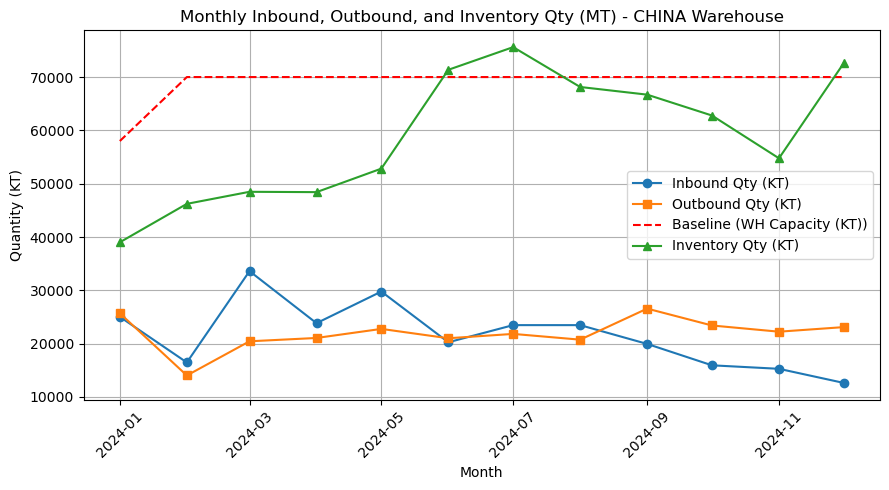

In [18]:
y = [58000]*1 + [70000] * 11
plt.figure(figsize=(9, 5))
plt.plot(df['month'], df['Quantity_KT_In'], marker='o', label='Inbound Qty (KT)')
plt.plot(df['month'], df['Quantity_KT_Out'], marker='s', label='Outbound Qty (KT)')
plt.plot(df['month'], y, color='r', linestyle='--', label='Baseline (WH Capacity (KT))')
plt.plot(df['month'], df['Quantity_MT_Inventory'], marker='^', label='Inventory Qty (KT)')
plt.title('Monthly Inbound, Outbound, and Inventory Qty (MT) - CHINA Warehouse')
plt.xlabel('Month')
plt.ylabel('Quantity (KT)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

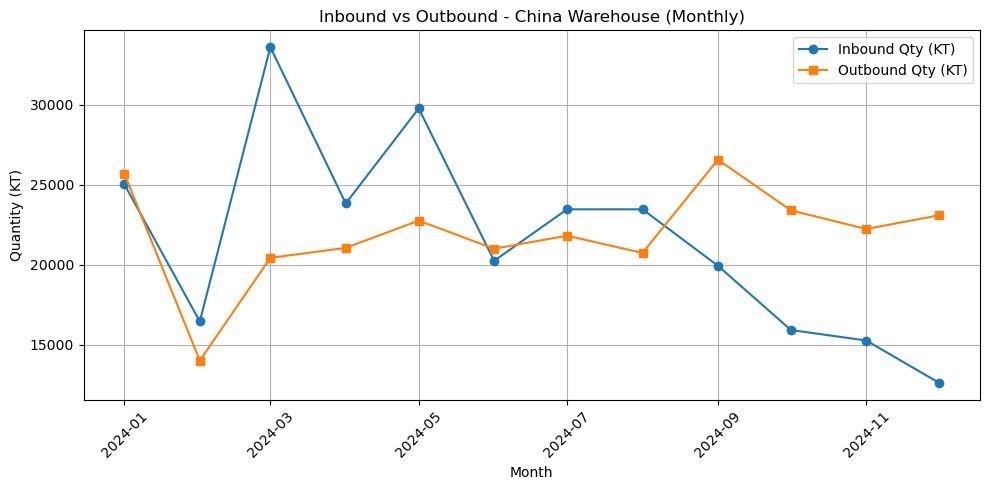

In [19]:
plt.figure(figsize=(10, 5))

plt.plot(df['month'], df['Quantity_KT_In'], marker='o', label='Inbound Qty (KT)')
plt.plot(df['month'], df['Quantity_KT_Out'], marker='s', label='Outbound Qty (KT)')

plt.title('Inbound vs Outbound - China Warehouse (Monthly)')
plt.xlabel('Month')
plt.ylabel('Quantity (KT)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

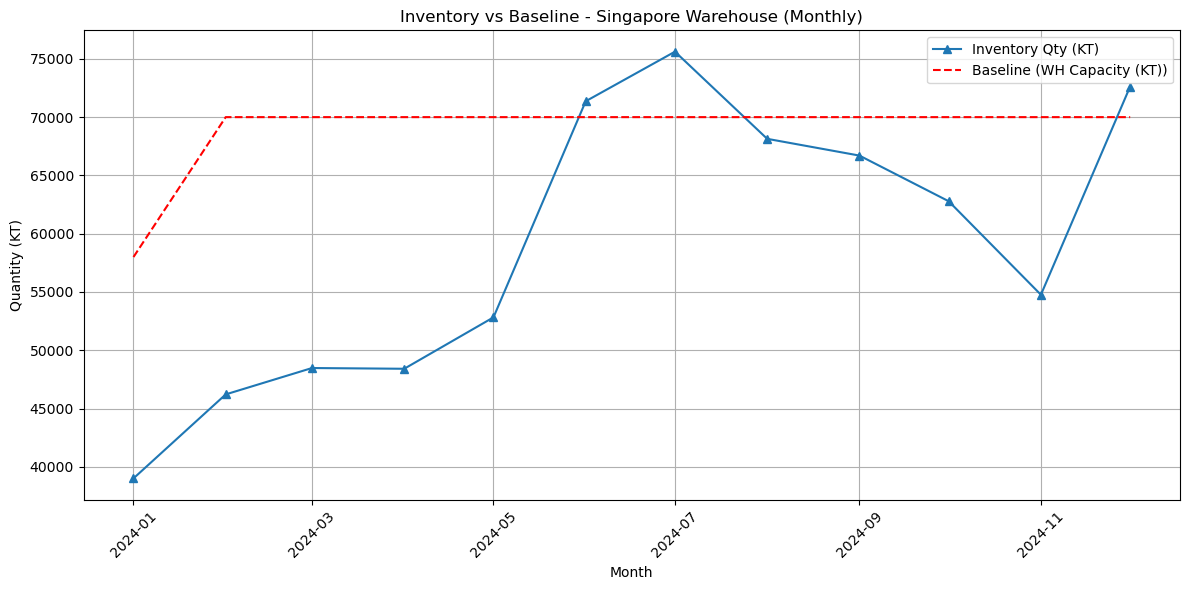

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(df['month'], df['Quantity_MT_Inventory'], marker='^', label='Inventory Qty (KT)')
plt.plot(df['month'], y, color='r', linestyle='--', label='Baseline (WH Capacity (KT))')
plt.title('Inventory vs Baseline - Singapore Warehouse (Monthly)')
plt.xlabel('Month')
plt.ylabel('Quantity (KT)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

# **Forecasting**

In [21]:
china_data = {
    'Month': ['Jan-24', 'Feb-24', 'Mar-24', 'Apr-24', 'May-24', 'Jun-24', 'Jul-24', 'Aug-24', 'Sep-24', 'Oct-24', 'Nov-24', 'Dec-24'],
    'Total Cap (KT)': [58000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000, 70000],
    'Predicted Outbound (KT)': [22600, 21700, 22000, 23100, 26700, 21900, 36200, 22900, 26400, 28600, 21100, 21800],
    'Predicted Inventory (KT)': [40000, 37000, 35000, 36000, 36000, 41000, 44000, 42000, 42000, 42000, 40000, 15000]
}
china_predicted = pd.DataFrame(china_data)
china_predicted['Month'] = pd.to_datetime(china_predicted['Month'], format='%b-%y').dt.to_period('M')

In [22]:
china_predicted

,Month,Total Cap (KT),Predicted Outbound (KT),Predicted Inventory (KT)
0,2024-01,58000,22600,40000
1,2024-02,70000,21700,37000
2,2024-03,70000,22000,35000
3,2024-04,70000,23100,36000
4,2024-05,70000,26700,36000
5,2024-06,70000,21900,41000
6,2024-07,70000,36200,44000
7,2024-08,70000,22900,42000
8,2024-09,70000,26400,42000
9,2024-10,70000,28600,42000


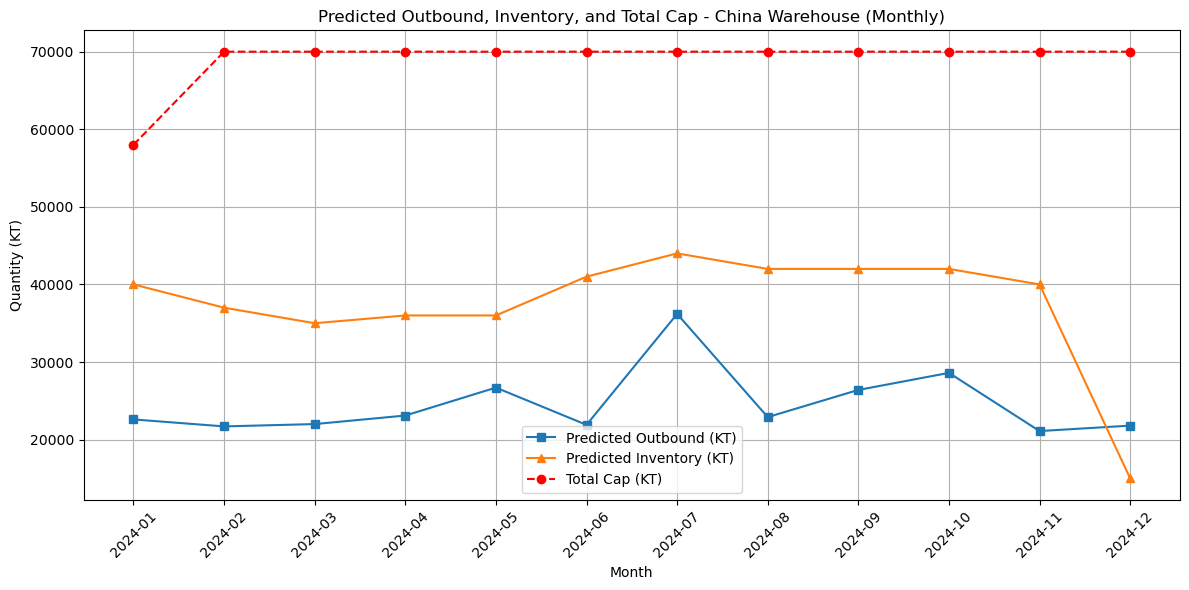

In [23]:
plt.figure(figsize=(12, 6))

plt.plot(china_predicted['Month'].astype(str), china_predicted['Predicted Outbound (KT)'], marker='s', label='Predicted Outbound (KT)')
plt.plot(china_predicted['Month'].astype(str), china_predicted['Predicted Inventory (KT)'], marker='^', label='Predicted Inventory (KT)')
plt.plot(china_predicted['Month'].astype(str), china_predicted['Total Cap (KT)'], marker='o', linestyle='--', color='red', label='Total Cap (KT)')

plt.title('Predicted Outbound, Inventory, and Total Cap - China Warehouse (Monthly)')
plt.xlabel('Month')
plt.ylabel('Quantity (KT)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Inventory Pred vs Actual**

In [24]:
comparison = df[['month', 'Quantity_MT_Inventory']].copy()
comparison['Predicted_Inventory'] = comparison['month'].apply(
    lambda m: china_predicted.loc[china_predicted['Month'].dt.to_timestamp() == m, 'Predicted Inventory (KT)'].values[0]
    if not china_predicted.loc[china_predicted['Month'].dt.to_timestamp() == m].empty else None
)
comparison['Deviation'] = comparison['Quantity_MT_Inventory'] - comparison['Predicted_Inventory']

print("Actual vs Predicted Inventory (China Warehouse):")
comparison

Actual vs Predicted Inventory (China Warehouse):


,month,Quantity_MT_Inventory,Predicted_Inventory,Deviation
0,2024-01-01,39012.368,40000,-987.632
1,2024-02-01,46217.648,37000,9217.648
2,2024-03-01,48478.708,35000,13478.708
3,2024-04-01,48415.015,36000,12415.015
4,2024-05-01,52826.486,36000,16826.486
5,2024-06-01,71362.441,41000,30362.441
6,2024-07-01,75614.624,44000,31614.624
7,2024-08-01,68138.683,42000,26138.683
8,2024-09-01,66701.368,42000,24701.368
9,2024-10-01,62785.369,42000,20785.369


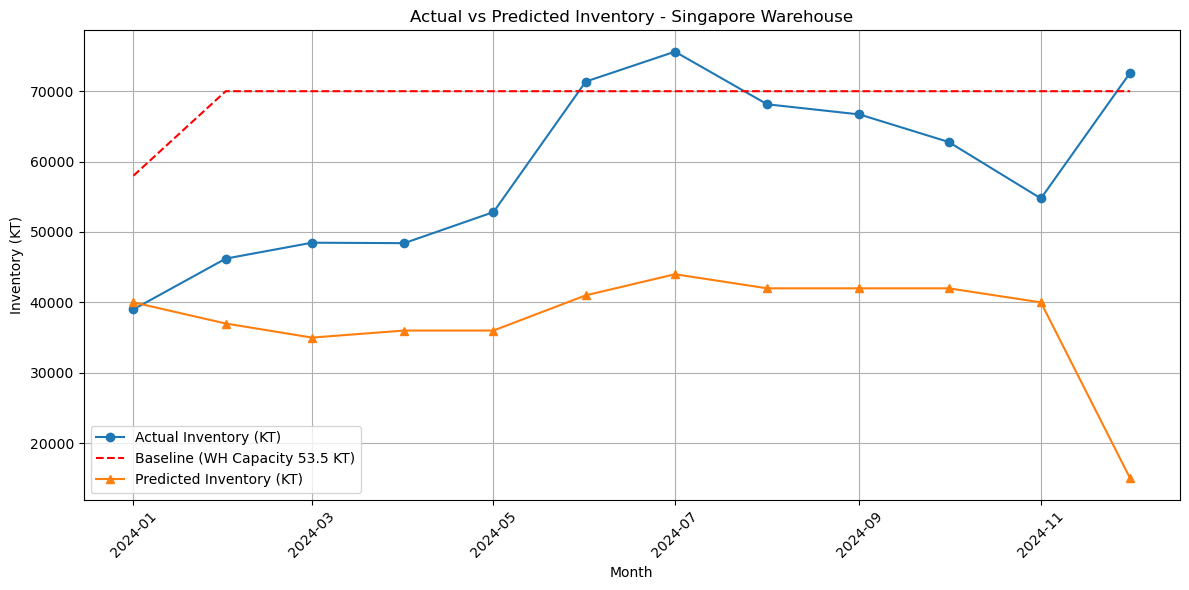

In [25]:
y = [58000]*1 + [70000] * 11
plt.figure(figsize=(12, 6))
plt.plot(df['month'], df['Quantity_MT_Inventory'], marker='o', label='Actual Inventory (KT)')
plt.plot(df['month'], y, color='r', linestyle='--', label='Baseline (WH Capacity 53.5 KT)')
plt.plot(china_predicted['Month'].dt.to_timestamp(), china_predicted['Predicted Inventory (KT)'], marker='^', label='Predicted Inventory (KT)')
plt.title('Actual vs Predicted Inventory - Singapore Warehouse')
plt.xlabel('Month')
plt.ylabel('Inventory (KT)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Adjust Inventory Predicted**

In [26]:
comparison_valid = comparison.dropna(subset=['Predicted_Inventory', 'Quantity_MT_Inventory'])

X = comparison_valid[['Predicted_Inventory']]
y = comparison_valid['Quantity_MT_Inventory']

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

cut_off_date = pd.to_datetime('2024-09-30')

train_mask = comparison_valid['month'] <= cut_off_date
test_mask = comparison_valid['month'] > cut_off_date

X_train = X_scaled[train_mask]
X_test = X_scaled[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.005,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=4,
    random_state=42
)

model.fit(X_train, y_train) 

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f"[Train] MAE: {mean_absolute_error(y_train, y_train_pred):.2f} | RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.2f}")
print(f"[Test ] MAE: {mean_absolute_error(y_test, y_test_pred):.2f} | RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}")

[Train] MAE: 7019.23 | RMSE: 8154.21
[Test ] MAE: 7001.35 | RMSE: 11186.33


In [27]:
X_all = scaler.transform(comparison[['Predicted_Inventory']].fillna(0))
comparison['Predicted_Adjusted'] = model.predict(X_all)
comparison['Deviation_Adjusted'] = comparison['Quantity_MT_Inventory'] - comparison['Predicted_Adjusted']


fig = px.line(comparison, x='month', y=['Quantity_MT_Inventory', 'Predicted_Inventory', 'Predicted_Adjusted'],
              title='Actual vs Predicted Inventory', markers=True)
fig.update_layout(yaxis_title='Inventory (KT)', xaxis_title='Month')
fig.show()

# **Outbound Pred vs Actual**

In [28]:
outbound_comparison = df[['month', 'Quantity_KT_Out']].copy()
outbound_comparison['Predicted_Outbound'] = outbound_comparison['month'].apply(
    lambda m: china_predicted.loc[china_predicted['Month'].dt.to_timestamp() == m, 'Predicted Outbound (KT)'].values[0]
    if not china_predicted.loc[china_predicted['Month'].dt.to_timestamp() == m].empty else None
)
outbound_comparison['Deviation'] = outbound_comparison['Quantity_KT_Out'] - outbound_comparison['Predicted_Outbound']

print("Actual vs Predicted Outbound (China Warehouse):")
outbound_comparison

Actual vs Predicted Outbound (China Warehouse):


,month,Quantity_KT_Out,Predicted_Outbound,Deviation
0,2024-01-01,25687.77,22600,3087.77
1,2024-02-01,14025.65,21700,-7674.35
2,2024-03-01,20438.56,22000,-1561.44
3,2024-04-01,21062.60,23100,-2037.40
4,2024-05-01,22762.81,26700,-3937.19
5,2024-06-01,21010.19,21900,-889.81
6,2024-07-01,21824.08,36200,-14375.92
7,2024-08-01,20744.91,22900,-2155.09
8,2024-09-01,26569.43,26400,169.43
9,2024-10-01,23404.13,28600,-5195.87


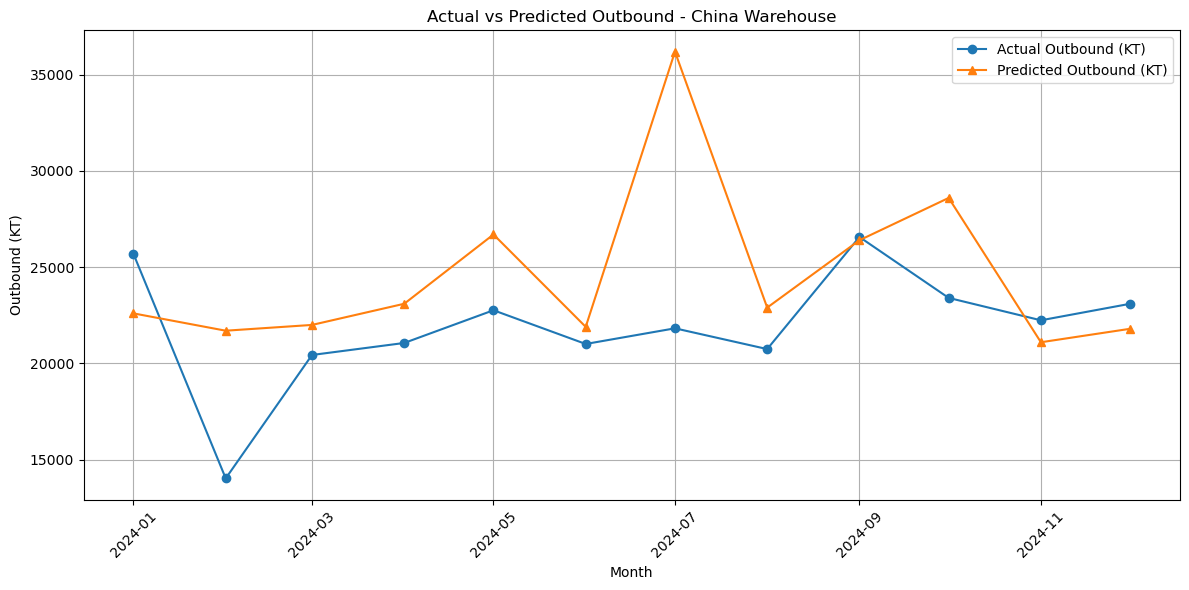

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(df['month'], df['Quantity_KT_Out'], marker='o', label='Actual Outbound (KT)')
plt.plot(china_predicted['Month'].dt.to_timestamp(), china_predicted['Predicted Outbound (KT)'], marker='^', label='Predicted Outbound (KT)')
plt.title('Actual vs Predicted Outbound - China Warehouse')
plt.xlabel('Month')
plt.ylabel('Outbound (KT)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Adjust Outbound Predicted**

In [30]:
outbound_valid = outbound_comparison.dropna(subset=['Predicted_Outbound', 'Quantity_KT_Out'])

X_out = outbound_valid[['Predicted_Outbound']]
y_out = outbound_valid['Quantity_KT_Out']

scaler_out = RobustScaler()
X_out_scaled = scaler_out.fit_transform(X_out)

train_mask = outbound_valid['month'] <= cut_off_date
test_mask = outbound_valid['month'] > cut_off_date

X_out_train = X_out_scaled[train_mask] 
X_out_test = X_out_scaled[test_mask]  
y_out_train = y_out[train_mask]      
y_out_test = y_out[test_mask]          

model = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=42
)

model.fit(X_out_train, y_out_train)

y_out_train_pred = model.predict(X_out_train)
y_out_test_pred = model.predict(X_out_test)

print(f"[Train] MAE: {mean_absolute_error(y_out_train, y_out_train_pred):.2f} | RMSE: {np.sqrt(mean_squared_error(y_out_train, y_out_train_pred)):.2f}")
print(f"[Test ] MAE: {mean_absolute_error(y_out_test, y_out_test_pred):.2f} | RMSE: {np.sqrt(mean_squared_error(y_out_test, y_out_test_pred)):.2f}")

[Train] MAE: 2022.04 | RMSE: 2537.07
[Test ] MAE: 2185.65 | RMSE: 2699.47


In [31]:
X_out_all = scaler_out.transform(outbound_comparison[['Predicted_Outbound']].fillna(0))
outbound_comparison['Predicted_Outbound_Adjusted'] = model.predict(X_out_all)
outbound_comparison['Deviation_Adjusted'] = outbound_comparison['Quantity_KT_Out'] - outbound_comparison['Predicted_Outbound_Adjusted']


fig = px.line(
    outbound_comparison,
    x='month',
    y=['Quantity_KT_Out', 'Predicted_Outbound', 'Predicted_Outbound_Adjusted'],
    title='Actual vs Predicted Outbound',
    markers=True
)

fig.update_layout(yaxis_title='Outbound (KT)', xaxis_title='Month')
fig.show()

---

# **Optimization**

### **Create Dataframe For Optimization Model**

In [32]:
optimize = pd.DataFrame({
    'Actual Inbound': Inbound_monthly_china['Quantity_KT_In'],
    'Actual Outbound': outbound_monthly_china['Quantity_KT_Out'],
    'Actual Inventory': Inventory_monthly_china['Quantity_MT_Inventory'],
    'Adjusted Inventory': comparison['Predicted_Adjusted'],
    'Adjusted Outbound': outbound_comparison['Predicted_Outbound_Adjusted'],
    'Capacity' : china_predicted['Total Cap (KT)'].values
})
optimize['Overflow'] = optimize['Adjusted Inventory'] > optimize['Capacity']

In [33]:
optimize

,Actual Inbound,Actual Outbound,Actual Inventory,Adjusted Inventory,Adjusted Outbound,Capacity,Overflow
0,25025.125,25687.77,39012.368,53307.351343,22136.794961,58000,False
1,16469.113,14025.65,46217.648,53307.351343,19391.611625,70000,False
2,33598.812,20438.56,48478.708,53307.351343,20025.015827,70000,False
3,23836.500,21062.60,48415.015,53307.351343,21977.253879,70000,False
4,29770.405,22762.81,52826.486,53307.351343,23404.747696,70000,False
5,20254.925,21010.19,71362.441,62557.646071,19391.611625,70000,False
6,23471.777,21824.08,75614.624,62557.646071,23404.747696,70000,False
7,23469.684,20744.91,68138.683,62557.646071,21924.838431,70000,False
8,19945.650,26569.43,66701.368,62557.646071,23637.344878,70000,False
9,15933.650,23404.13,62785.369,62557.646071,23404.747696,70000,False


In [34]:
# new_records = [
#     [12.0, 9.5, 60, 48.2, 11.0, 53.5, True],
#     [7.5, 13.0, 44.0, 45.0, 13.1, 53.5, False],
#     [11.3, 14.8, 59, 43.0, 12.5, 53.5, True]
# ]

# columns = ['Actual Inbound', 'Actual Outbound', 'Actual Inventory',
#            'Adjusted Inventory', 'Adjusted Outbound', 'Capacity', 'Overflow']

# new_df = pd.DataFrame(new_records, columns=columns)
# optimize = pd.concat([optimize, new_df], ignore_index=True)


# optimize.tail()

### ---**You Can Append New Records to the `optimize` DataFrame**---

## **Optimization Model Function: Backtesting on Historical Data**

- **Define a Function that applies the optimization logic using historical data to verify model correctness, behavior, and feasibility before applying to future scenarios.**

In [35]:
from pulp import *

def run_optimization(optimize):
    model = LpProblem("Inventory_Optimization", LpMinimize)
    n = len(optimize)

    inbound_vars = [LpVariable(f"Inbound_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    outbound_vars = [LpVariable(f"Outbound_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    inventory_vars = [LpVariable(f"Inventory_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    overflow_vars = [LpVariable(f"Overflow_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    understock_vars = [LpVariable(f"Understock_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    deviation_vars = [LpVariable(f"InvDeviation_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]

    capacity = optimize['Capacity'].values
    adjusted_outbound = optimize['Actual Outbound'].values
    cap_70 = 0.70 * capacity
    cap_80 = 0.80 * capacity
    target_inventory = 0.75 * capacity

    # Weights (can be tuned)
    overflow_penalty = 1
    understock_penalty = 1
    deviation_penalty = 2  # Make this >1 to encourage staying near target
    outbound_reward = 1

    # Objective Function
    model += (
        lpSum(overflow_penalty * overflow_vars[i] +
              understock_penalty * understock_vars[i] +
              deviation_penalty * deviation_vars[i] -
              outbound_reward * outbound_vars[i]
              for i in range(n))
    )

    for i in range(n):
        if i == 0:
            model += inventory_vars[i] == optimize['Actual Inventory'].iloc[0] + inbound_vars[i] - outbound_vars[i]
        else:
            model += inventory_vars[i] == inventory_vars[i - 1] + inbound_vars[i] - outbound_vars[i]

        model += outbound_vars[i] <= adjusted_outbound[i]
        model += inbound_vars[i] >= 5  # Minimum inbound constraint

        # Overflow and understock constraints
        model += overflow_vars[i] >= inventory_vars[i] - cap_80[i]
        model += understock_vars[i] >= cap_70[i] - inventory_vars[i]

        # Target deviation constraint
        model += deviation_vars[i] >= inventory_vars[i] - target_inventory[i]
        model += deviation_vars[i] >= target_inventory[i] - inventory_vars[i]

    # Solve
    model.solve()

    # Write back results
    optimize['Optimized Inbound'] = [inbound_vars[i].varValue for i in range(n)]
    optimize['Optimized Outbound'] = [outbound_vars[i].varValue for i in range(n)]
    optimize['Optimized Inventory'] = [inventory_vars[i].varValue for i in range(n)]
    optimize['Overflow'] = [overflow_vars[i].varValue for i in range(n)]
    optimize['Understock'] = [understock_vars[i].varValue for i in range(n)]
    optimize['Inventory Deviation'] = [deviation_vars[i].varValue for i in range(n)]
    optimize['Cap_70'] = cap_70
    optimize['Cap_75'] = target_inventory
    optimize['Cap_80'] = cap_80

    return optimize


In [36]:
opt_head_9 = optimize.head(9).copy()

In [37]:
opt_head_9 = run_optimization(opt_head_9)
opt_head_9['Cap_70'] = opt_head_9['Capacity'] * 0.70
opt_head_9['Cap_80'] = opt_head_9['Capacity'] * 0.80

In [38]:
opt_head_9

,Actual Inbound,Actual Outbound,Actual Inventory,Adjusted Inventory,Adjusted Outbound,Capacity,Overflow,Optimized Inbound,Optimized Outbound,Optimized Inventory,Understock,Inventory Deviation,Cap_70,Cap_75,Cap_80
0,25025.125,25687.77,39012.368,53307.351343,22136.794961,58000,0.0,30175.402,25687.77,43500.0,0.0,0.0,40600.0,43500.0,46400.0
1,16469.113,14025.65,46217.648,53307.351343,19391.611625,70000,0.0,23025.650,14025.65,52500.0,0.0,0.0,49000.0,52500.0,56000.0
2,33598.812,20438.56,48478.708,53307.351343,20025.015827,70000,0.0,20438.560,20438.56,52500.0,0.0,0.0,49000.0,52500.0,56000.0
3,23836.500,21062.60,48415.015,53307.351343,21977.253879,70000,0.0,21062.600,21062.60,52500.0,0.0,0.0,49000.0,52500.0,56000.0
4,29770.405,22762.81,52826.486,53307.351343,23404.747696,70000,0.0,22762.810,22762.81,52500.0,0.0,0.0,49000.0,52500.0,56000.0
5,20254.925,21010.19,71362.441,62557.646071,19391.611625,70000,0.0,21010.190,21010.19,52500.0,0.0,0.0,49000.0,52500.0,56000.0
6,23471.777,21824.08,75614.624,62557.646071,23404.747696,70000,0.0,21824.080,21824.08,52500.0,0.0,0.0,49000.0,52500.0,56000.0
7,23469.684,20744.91,68138.683,62557.646071,21924.838431,70000,0.0,20744.910,20744.91,52500.0,0.0,0.0,49000.0,52500.0,56000.0
8,19945.650,26569.43,66701.368,62557.646071,23637.344878,70000,0.0,26569.430,26569.43,52500.0,0.0,0.0,49000.0,52500.0,56000.0


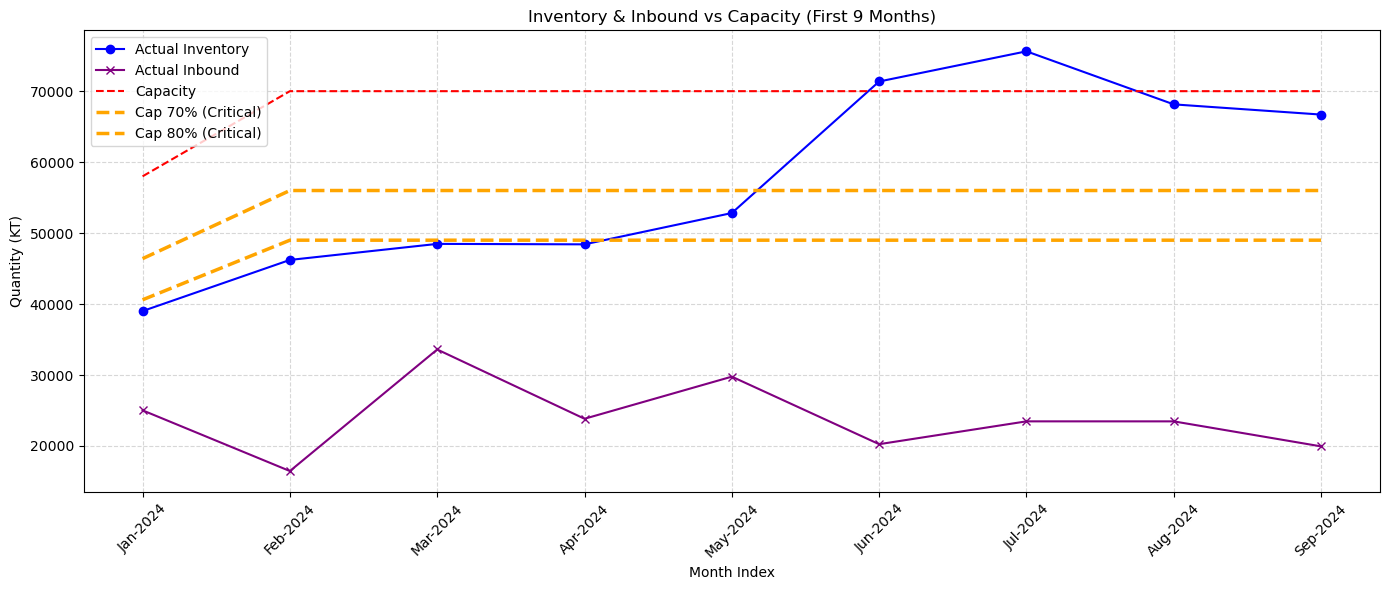

In [39]:
opt_head_9 = opt_head_9.sort_index()
x1 = opt_head_9.index
month_labels = df.loc[x1, 'month'].dt.strftime('%b-%Y').values
plt.figure(figsize=(14,6))
# plt.plot(x1, opt_head_9['Actual Outbound'], label='Actual Outbound', color='black', marker='o')
plt.plot(x1, opt_head_9['Actual Inventory'], label='Actual Inventory', color='blue', marker='o')
plt.plot(x1, opt_head_9['Actual Inbound'], label='Actual Inbound', color='purple', marker='x')
# plt.plot(x1, opt_head_9['Actual Outbound'], label='Actual Outbound', color='black', marker='o')
# plt.plot(x1, opt_head_9['Optimized Inventory'], label='Optimized Inventory', color='blue', marker='^')
# plt.plot(x1, opt_head_9['Optimized Inbound'], label='Optimized Inbound', color='purple', marker='s')

plt.plot(x1, opt_head_9['Capacity'], label='Capacity', color='red', linestyle='--')
# plt.plot(x1, opt_head_9['Cap_70'], label='Cap 70%', color='gray', linestyle='--')
plt.plot(x1, opt_head_9['Cap_70'], label='Cap 70% (Critical)', color='orange', linestyle='--', linewidth=2.5)
plt.plot(x1, opt_head_9['Cap_80'], label='Cap 80% (Critical)', color='orange', linestyle='--', linewidth=2.5)


plt.title('Inventory & Inbound vs Capacity (First 9 Months)')
plt.xlabel('Month Index')
plt.ylabel('Quantity (KT)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(x1, month_labels, rotation=45)
plt.tight_layout()
plt.show()

---

## **Build a New Optimization Function for `pred_data`**

- **Construct a new optimization function that applies the same logic as the previous model, adapted to handle `pred_data` (forecasted or incoming new data).**

In [40]:
def run_forecast_optimization(df_forecast, last_inventory, fixed_inbound_dict=None):
    n = len(df_forecast)

    model = LpProblem("Inventory_Optimization", LpMinimize)

    # Variables
    inbound_vars = [LpVariable(f"Inbound_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    outbound_vars = [LpVariable(f"Outbound_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    inventory_vars = [LpVariable(f"Inventory_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    overflow_vars = [LpVariable(f"Overflow_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]
    understock_vars = [LpVariable(f"Understock_{i}", lowBound=0, cat=LpContinuous) for i in range(n)]

    # Parameters
    adjusted_outbound = df_forecast['Adjusted Outbound'].values
    capacity = df_forecast['Capacity'].values

    cap_80 = 0.8 * capacity
    cap_70 = 0.7 * capacity

    # Inventory balance constraint
    for i in range(n):
        if i == 0:
            model += inventory_vars[i] == last_inventory + inbound_vars[i] - outbound_vars[i]
        else:
            model += inventory_vars[i] == inventory_vars[i-1] + inbound_vars[i] - outbound_vars[i]

    # Fix inbound where known (if fixed_inbound_dict is provided)
    if fixed_inbound_dict:
        for relative_idx, value in fixed_inbound_dict.items():
            if 0 <= relative_idx < n:
                model += inbound_vars[relative_idx] == value

    # Outbound constraints
    for i in range(n):
        model += outbound_vars[i] <= adjusted_outbound[i]
        model += inbound_vars[i] >= 5  # Min inbound

    # Overflow & understock constraints
    for i in range(n):
        model += overflow_vars[i] >= inventory_vars[i] - cap_80[i]
        model += overflow_vars[i] >= 0
        model += understock_vars[i] >= cap_70[i] - inventory_vars[i]
        model += understock_vars[i] >= 0

    # Objective
    model += -lpSum(outbound_vars) + lpSum(overflow_vars) * 1 + lpSum(understock_vars) * 1

    model.solve()

    # Results
    df_result = df_forecast.copy()
    df_result['Optimized Inbound'] = [v.value() for v in inbound_vars]
    df_result['Optimized Outbound'] = [v.value() for v in outbound_vars]
    df_result['Optimized Inventory'] = [v.value() for v in inventory_vars]
    df_result['Overflow'] = [v.value() for v in overflow_vars]
    df_result['Understock'] = [v.value() for v in understock_vars]
    df_result['Cap_70'] = cap_70
    df_result['Cap_80'] = cap_80

    return df_result

In [41]:
optimize.index = optimize.index+1
optimize

,Actual Inbound,Actual Outbound,Actual Inventory,Adjusted Inventory,Adjusted Outbound,Capacity,Overflow
1,25025.125,25687.77,39012.368,53307.351343,22136.794961,58000,False
2,16469.113,14025.65,46217.648,53307.351343,19391.611625,70000,False
3,33598.812,20438.56,48478.708,53307.351343,20025.015827,70000,False
4,23836.500,21062.60,48415.015,53307.351343,21977.253879,70000,False
5,29770.405,22762.81,52826.486,53307.351343,23404.747696,70000,False
6,20254.925,21010.19,71362.441,62557.646071,19391.611625,70000,False
7,23471.777,21824.08,75614.624,62557.646071,23404.747696,70000,False
8,23469.684,20744.91,68138.683,62557.646071,21924.838431,70000,False
9,19945.650,26569.43,66701.368,62557.646071,23637.344878,70000,False
10,15933.650,23404.13,62785.369,62557.646071,23404.747696,70000,False


### **Initial Target for the New Optimization Model: `optimize.iloc[-3:]` (Last 3 Records)**

In [42]:
# opt_last3 = optimize.iloc[-3:].copy()
opt_last3 = optimize.iloc[-3:].copy()

In [43]:
opt_last3

,Actual Inbound,Actual Outbound,Actual Inventory,Adjusted Inventory,Adjusted Outbound,Capacity,Overflow
10,15933.650,23404.13,62785.369,62557.646071,23404.747696,70000,False
11,15277.488,22240.40,54764.596,53307.351343,19391.611625,70000,False
12,12629.075,23099.15,72626.420,53307.351343,19391.611625,70000,False


- **The latest inventory value is a key input to the optimization model, as all calculations are anchored from this current stock level.**

In [44]:
opt_start_idx = opt_last3.index[0] 
last_inventory = optimize.loc[opt_start_idx - 1, 'Actual Inventory']
last_inventory

66701.368

In [45]:
fixed_inbound_dict = {
    0: optimize.loc[opt_start_idx, 'Actual Inbound'],       # เดือน 10
    1: optimize.loc[opt_start_idx + 1, 'Actual Inbound'],   # เดือน 11
}

In [46]:
opt_last3 = run_forecast_optimization(opt_last3, last_inventory, fixed_inbound_dict=fixed_inbound_dict)
opt_last3 = opt_last3.sort_index()

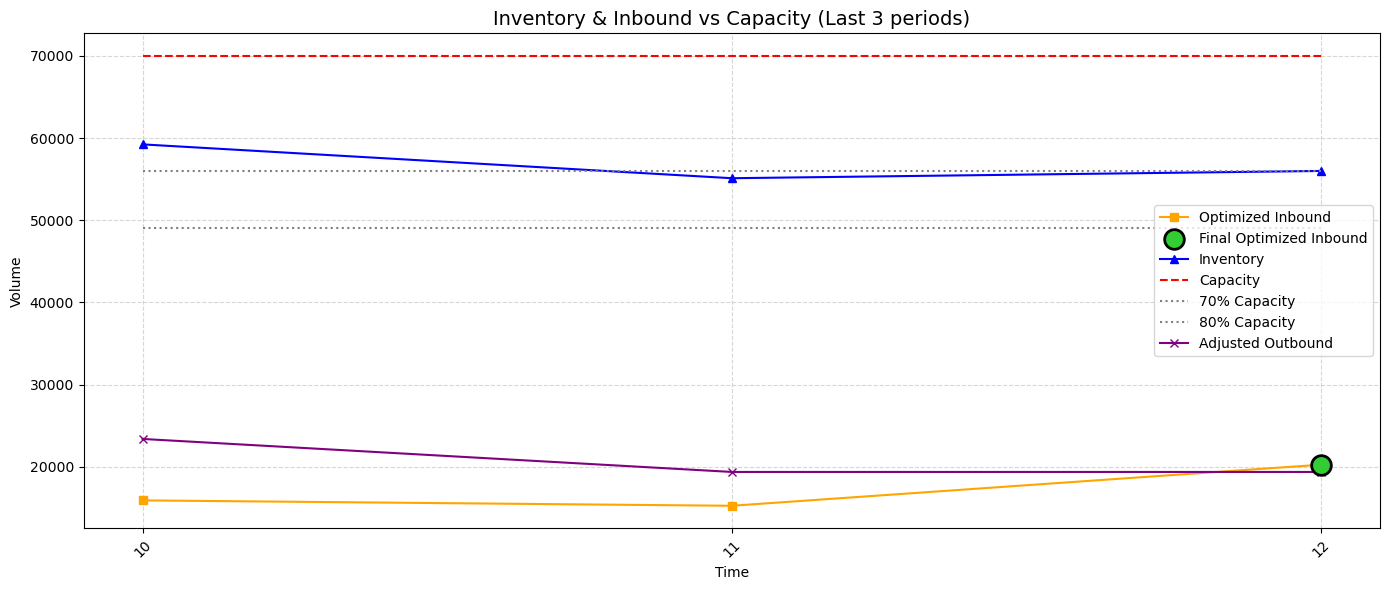

In [47]:
x = opt_last3.index
y_inbound = opt_last3['Optimized Inbound']

plt.figure(figsize=(14,6))

# เส้นหลัก Optimized Inbound
plt.plot(x, y_inbound, label='Optimized Inbound', color='orange', marker='s')

# จุดสุดท้าย (เด่นๆ)
last_x = x[-1]
last_y = y_inbound.iloc[-1]

plt.scatter(
    last_x, last_y,
    color='limegreen',       # สีเขียวเด่น
    s=200,                   # ขนาดใหญ่
    edgecolors='black',      # ขอบดำ
    linewidths=2,
    zorder=10,               # ให้อยู่บนสุด
    label='Final Optimized Inbound'
)

# เพิ่ม Annotation
# plt.annotate(
#     f'Final: {last_y:.0f}',
#     xy=(last_x, last_y),
#     xytext=(last_x, last_y + 60),  # ปรับระยะห่างข้อความ
#     fontsize=11,
#     color='green',
#     weight='bold',
#     arrowprops=dict(
#         facecolor='limegreen',
#         edgecolor='black',
#         arrowstyle='->',
#         lw=2
#     )
# )

# เส้นอื่น ๆ
plt.plot(x, opt_last3['Optimized Inventory'], label='Inventory', color='blue', marker='^')
plt.plot(x, opt_last3['Capacity'], label='Capacity', color='red', linestyle='--')
plt.plot(x, opt_last3['Cap_70'], label='70% Capacity', color='gray', linestyle=':')
plt.plot(x, opt_last3['Cap_80'], label='80% Capacity', color='gray', linestyle=':')
plt.plot(x, opt_last3['Adjusted Outbound'], label='Adjusted Outbound', color='purple', marker='x')
# รูปแบบกราฟ
plt.title('Inventory & Inbound vs Capacity (Last 3 periods)', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(x, x, rotation=45)
plt.tight_layout()
plt.show()


In [48]:
combined_df = pd.concat([opt_head_9, opt_last3], ignore_index=True)

In [49]:
combined_df.to_csv('optim_china.csv', index=False, encoding='utf-8-sig')

In [50]:
combined_df

,Actual Inbound,Actual Outbound,Actual Inventory,Adjusted Inventory,Adjusted Outbound,Capacity,Overflow,Optimized Inbound,Optimized Outbound,Optimized Inventory,Understock,Inventory Deviation,Cap_70,Cap_75,Cap_80
0,25025.125,25687.77,39012.368,53307.351343,22136.794961,58000,0.0000,30175.402,25687.770,43500.000,0.0,0.0,40600.0,43500.0,46400.0
1,16469.113,14025.65,46217.648,53307.351343,19391.611625,70000,0.0000,23025.650,14025.650,52500.000,0.0,0.0,49000.0,52500.0,56000.0
2,33598.812,20438.56,48478.708,53307.351343,20025.015827,70000,0.0000,20438.560,20438.560,52500.000,0.0,0.0,49000.0,52500.0,56000.0
3,23836.500,21062.60,48415.015,53307.351343,21977.253879,70000,0.0000,21062.600,21062.600,52500.000,0.0,0.0,49000.0,52500.0,56000.0
4,29770.405,22762.81,52826.486,53307.351343,23404.747696,70000,0.0000,22762.810,22762.810,52500.000,0.0,0.0,49000.0,52500.0,56000.0
5,20254.925,21010.19,71362.441,62557.646071,19391.611625,70000,0.0000,21010.190,21010.190,52500.000,0.0,0.0,49000.0,52500.0,56000.0
6,23471.777,21824.08,75614.624,62557.646071,23404.747696,70000,0.0000,21824.080,21824.080,52500.000,0.0,0.0,49000.0,52500.0,56000.0
7,23469.684,20744.91,68138.683,62557.646071,21924.838431,70000,0.0000,20744.910,20744.910,52500.000,0.0,0.0,49000.0,52500.0,56000.0
8,19945.650,26569.43,66701.368,62557.646071,23637.344878,70000,0.0000,26569.430,26569.430,52500.000,0.0,0.0,49000.0,52500.0,56000.0
9,15933.650,23404.13,62785.369,62557.646071,23404.747696,70000,3230.2703,15933.650,23404.748,59230.270,0.0,NaN,49000.0,NaN,56000.0


---

**End of Notebook – Thank you**